In [124]:
# 사용할 모듈 불러오기 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import xgboost

In [125]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')

In [126]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [127]:
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

In [128]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


In [129]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

In [130]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

In [131]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [132]:
item_categories.head(3)

,item_category_name,item_category_id,high_category_name,high_category_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1


In [133]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [134]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


In [135]:
test.columns , train.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
        'item_cnt_day'],
       dtype='object'))

In [136]:
test['date_block_num'] = 34
test['item_price'] = 1
test['item_cnt_day'] = 0
del train['date']
del test['ID']

In [137]:
pd.concat([test,train])

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,5,5037,34,1.0,0.0
1,5,5320,34,1.0,0.0
2,5,5233,34,1.0,0.0
3,5,5232,34,1.0,0.0
4,5,5268,34,1.0,0.0
...,...,...,...,...,...
2935844,25,7409,33,299.0,1.0
2935845,25,7460,33,299.0,1.0
2935846,25,7459,33,349.0,1.0
2935847,25,7440,33,299.0,1.0


In [138]:
pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,16,18336,0,299.0,1.0
1,25,18631,0,149.0,1.0
2,25,19333,0,350.0,1.0
3,25,19330,0,349.0,1.0
4,25,18546,0,149.0,1.0
...,...,...,...,...,...
3142682,57,18454,34,1.0,0.0
3142683,57,18027,34,1.0,0.0
3142684,57,18049,34,1.0,0.0
3142685,57,18589,34,1.0,0.0


In [139]:
train_df = pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)
train_df

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,16,18336,0,299.0,1.0
1,25,18631,0,149.0,1.0
2,25,19333,0,350.0,1.0
3,25,19330,0,349.0,1.0
4,25,18546,0,149.0,1.0
...,...,...,...,...,...
3142682,57,18454,34,1.0,0.0
3142683,57,18027,34,1.0,0.0
3142684,57,18049,34,1.0,0.0
3142685,57,18589,34,1.0,0.0


In [140]:
train_df = train_df.pivot_table(index = ['date_block_num','shop_id','item_id','item_price'] , values=['item_cnt_day'],aggfunc='sum')
train_df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
train_df

item_cnt_month
date_block_num shop_id item_id item_price                
0              2       27      2499.0                 1.0
                       33      499.0                  1.0
                       317     299.0                  1.0
                       438     299.0                  1.0
                       471     399.0                  2.0
...                                                   ...
34             59      22162   1.0                    0.0
                       22163   1.0                    0.0
                       22164   1.0                    0.0
                       22166   1.0                    0.0
                       22167   1.0                    0.0

[1951246 rows x 1 columns]

In [141]:
train_df = train_df.reset_index()
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,2,27,2499.0,1.0
1,0,2,33,499.0,1.0
2,0,2,317,299.0,1.0
3,0,2,438,299.0,1.0
4,0,2,471,399.0,2.0
...,...,...,...,...,...
1951241,34,59,22162,1.0,0.0
1951242,34,59,22163,1.0,0.0
1951243,34,59,22164,1.0,0.0
1951244,34,59,22166,1.0,0.0


In [142]:
train_df = pd.merge(train_df ,shops ,on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month,city_id
0,0,2,27,2499.0,1.0,0
1,0,2,33,499.0,1.0,0
2,0,2,317,299.0,1.0,0
3,0,2,438,299.0,1.0,0
4,0,2,471,399.0,2.0,0
...,...,...,...,...,...,...
1951241,34,36,22162,1.0,0.0,16
1951242,34,36,22163,1.0,0.0,16
1951243,34,36,22164,1.0,0.0,16
1951244,34,36,22166,1.0,0.0,16


In [143]:
item_high_categories = items.merge(item_categories).drop(['item_name','item_category_name','high_category_name'],axis = 1)
item_high_categories.head(3)

,item_id,item_category_id,high_category_id
0,0,40,7
1,2,40,7
2,3,40,7


In [144]:
train_df = pd.merge(train_df ,item_high_categories ,on =  'item_id')
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month,city_id,item_category_id,high_category_id
0,0,2,27,2499.0,1.0,0,19,5
1,17,2,27,498.0,1.0,0,19,5
2,11,3,27,998.0,1.0,1,19,5
3,16,4,27,498.0,1.0,2,19,5
4,17,6,27,498.0,1.0,4,19,5
...,...,...,...,...,...,...,...,...
1951241,33,20,21003,1899.0,1.0,13,61,10
1951242,33,20,21008,1899.0,5.0,13,61,10
1951243,33,20,21012,1899.0,1.0,13,61,10
1951244,33,20,21047,1899.0,1.0,13,61,10


In [147]:
train_df['item_revenue_month'] = train_df.item_cnt_month * train_df.item_price
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month,city_id,item_category_id,high_category_id,item_revenue_month
0,0,2,27,2499.0,1.0,0,19,5,2499.0
1,17,2,27,498.0,1.0,0,19,5,498.0
2,11,3,27,998.0,1.0,1,19,5,998.0
3,16,4,27,498.0,1.0,2,19,5,498.0
4,17,6,27,498.0,1.0,4,19,5,498.0
...,...,...,...,...,...,...,...,...,...
1951241,33,20,21003,1899.0,1.0,13,61,10,1899.0
1951242,33,20,21008,1899.0,5.0,13,61,10,9495.0
1951243,33,20,21012,1899.0,1.0,13,61,10,1899.0
1951244,33,20,21047,1899.0,1.0,13,61,10,1899.0


In [148]:
base_item_feature_names = ['item_id','item_category_id','high_category_id']
base_place_feature_names = ['shop_id','city_id']
mean_feature_names = ['item_cnt_month','item_revenue_month']

In [149]:
def add_mean_feature(df , base_feature_names ,mean_feature_names):
    '''
    base_feature_name를 기준으로 mean_feature_names의 값들을 
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    df_pivot  = df[list(base_feature_names) + list(mean_feature_names)]
    col_name = ''
    for base_feature_name in base_feature_names:
        if base_feature_name !='date_block_num':
            col_name += '_'.join(base_feature_name.split('_')[:-1])+'_'

    for mean_feature_name in mean_feature_names:
        df_pivot = df_pivot.rename(columns = {mean_feature_name:col_name + mean_feature_name.split('_')[1]+'_month_mean'})

    df_pivot = df_pivot.pivot_table(index = base_feature_names)
    df = df.merge(df_pivot , on =base_feature_names)
    return df

In [151]:
for place in base_place_feature_names:
    for item in base_item_feature_names:
        base_feature_names = ['date_block_num', place,item]
        train_df = add_mean_feature(train_df ,base_feature_names,mean_feature_names)

In [152]:
train_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month',
       'city_id', 'item_category_id', 'high_category_id', 'item_revenue_month',
       'shop_item_cnt_month_mean', 'shop_item_revenue_month_mean',
       'shop_item_category_cnt_month_mean',
       'shop_item_category_revenue_month_mean',
       'shop_high_category_cnt_month_mean',
       'shop_high_category_revenue_month_mean', 'city_item_cnt_month_mean',
       'city_item_revenue_month_mean', 'city_item_category_cnt_month_mean',
       'city_item_category_revenue_month_mean',
       'city_high_category_cnt_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

In [153]:
train_df.drop(base_item_feature_names+base_place_feature_names , axis =1  , inplace = True)

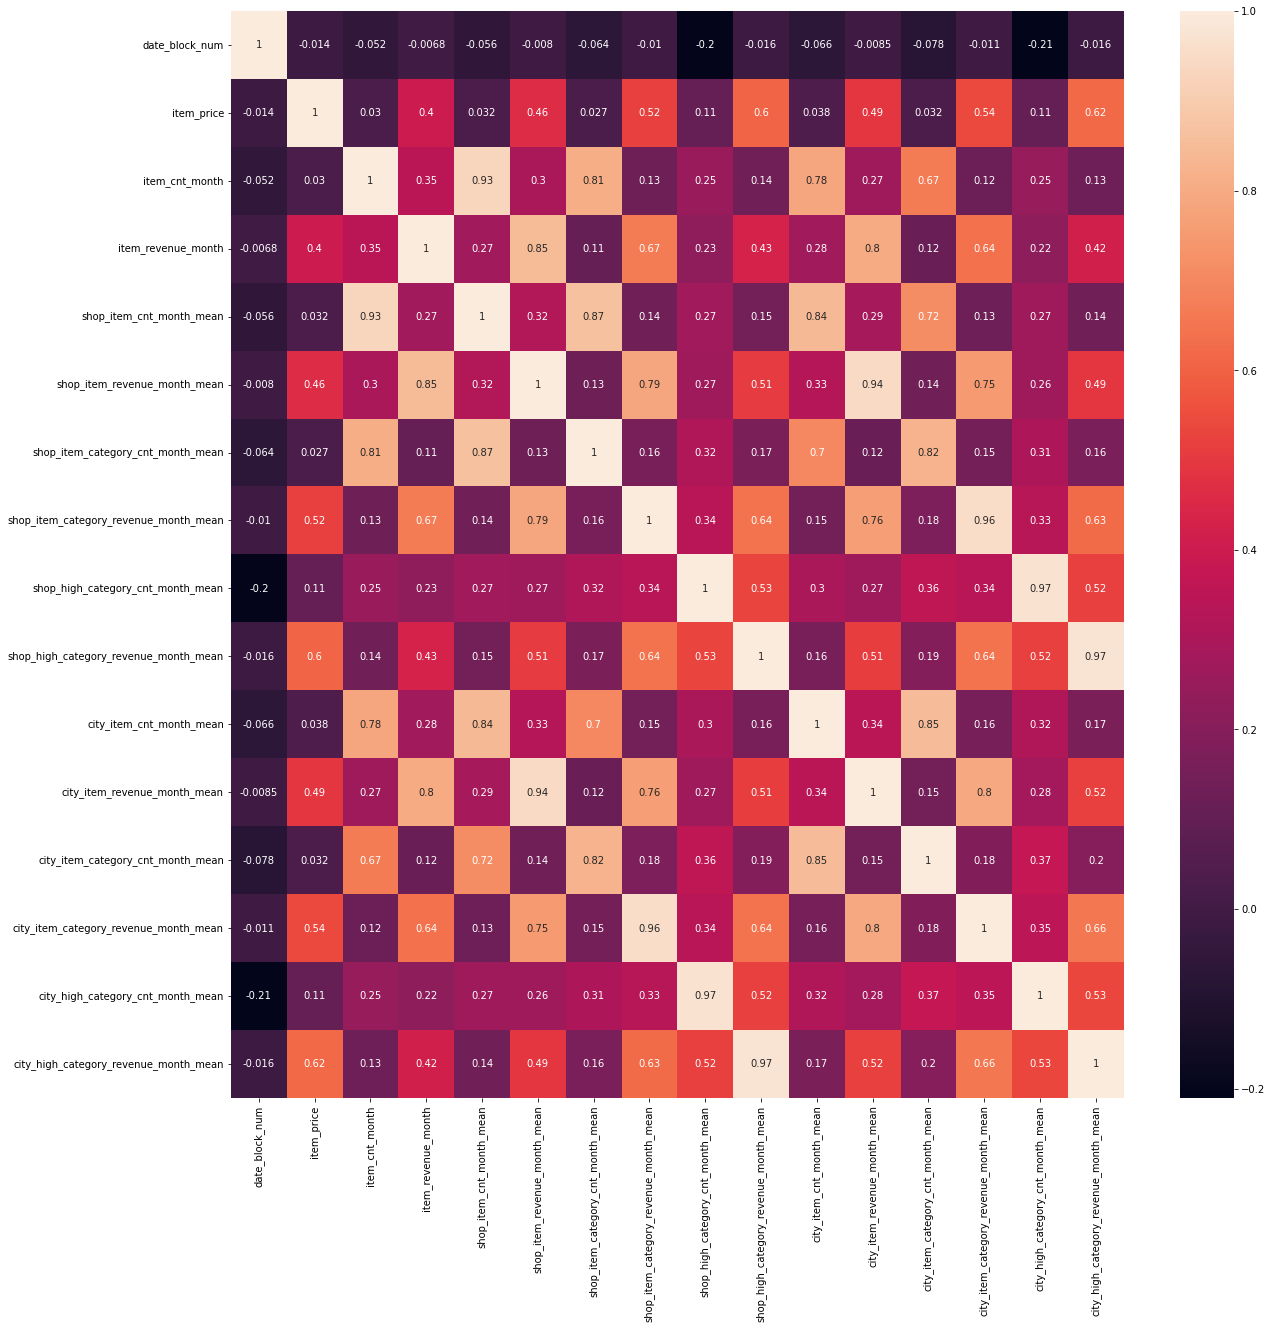

In [154]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr() , annot=True)
plt.show()

In [155]:
x_train = train_df[train_df['date_block_num'] < 33]
x_train = x_train.drop('item_cnt_month', axis = 1)
y_train = train_df[train_df['date_block_num'] < 33]['item_cnt_month']

x_valid = train_df[train_df['date_block_num'] == 33]
x_valid = x_valid.drop('item_cnt_month', axis = 1)
y_valid = train_df[train_df['date_block_num'] == 33]['item_cnt_month']

x_test = train_df[train_df['date_block_num'] == 34]
x_test = x_test.drop('item_cnt_month', axis = 1)
y_test = train_df[train_df['date_block_num'] == 34]['item_cnt_month']

In [156]:
from lightgbm import LGBMRegressor

In [157]:
model=LGBMRegressor(
        n_estimators=200,
        learning_rate=0.03,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40)

In [158]:
print('Training time, it is...')
model.fit(x_train, y_train,)

Training time, it is...


LGBMRegressor(colsample_bytree=0.9497036, learning_rate=0.03, max_depth=8,
              min_child_weight=40, min_split_gain=0.0222415, n_estimators=200,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.8715623)

In [159]:
x_test

,date_block_num,item_price,item_revenue_month,shop_item_cnt_month_mean,shop_item_revenue_month_mean,shop_item_category_cnt_month_mean,shop_item_category_revenue_month_mean,shop_high_category_cnt_month_mean,shop_high_category_revenue_month_mean,city_item_cnt_month_mean,city_item_revenue_month_mean,city_item_category_cnt_month_mean,city_item_category_revenue_month_mean,city_high_category_cnt_month_mean,city_high_category_revenue_month_mean
55702,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55703,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55704,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55705,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55706,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951112,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951113,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951114,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951115,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# Get the test set predictions and clip values to the specified range
y_pred = model.predict(x_test).clip(0., 20.)

# Create the submission file and submit!
preds = pd.DataFrame(y_pred, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')